In [3]:
import math
import pandas as pd
import tensorflow as tf
# import keras_tuner.tuners as kt
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError
import numpy as np
import pickle
np.random.seed(0)
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv1D, Conv2D, LeakyReLU, MaxPool1D, AveragePooling1D, UpSampling1D, Flatten, Dense, Reshape, BatchNormalization
# https://towardsdatascience.com/improve-your-model-performance-with-auto-encoders-d4ee543b4154
from tensorflow.keras import initializers
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from scipy.stats import multivariate_normal
from keras.optimizers import Adam, SGD, Adadelta

from keras.optimizers import Adam, SGD, Adadelta

In [4]:
x_train_scaled = pd.read_csv('../260_sample_train_scaled.csv').set_index("Patient_ID")
x_train_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
55_control,0.702813,0.799052,0.719665,0.729547,0.794953,0.256451,1.000000,0.363133,0.374212,0.611161,...,0.468042,0.335792,0.0,0.609518,0.535456,0.0,0.543158,0.622641,0.0,1.0
168_CD_plain,0.751408,0.603707,0.622768,0.627712,0.606860,0.520576,0.311962,0.251356,0.553554,0.441131,...,0.000000,0.159464,0.0,0.173529,0.018188,0.0,0.623796,0.301179,0.0,0.0
72_control,0.786508,0.755331,0.739605,0.756170,0.819875,0.391132,0.648401,0.134017,0.200420,0.679453,...,0.335173,0.241577,0.0,0.659563,0.000000,0.0,0.853118,0.431083,0.0,0.0
120_control,0.707491,0.662993,0.648072,0.764621,0.654276,0.633929,0.579519,0.248934,0.759250,0.755407,...,0.181256,0.297248,0.0,0.837676,0.480372,0.0,0.392582,0.390569,0.0,0.0
258_CD_plain,0.701039,0.662511,0.707208,0.834562,0.670160,0.410612,0.370517,0.244987,0.445387,0.798000,...,0.319013,0.306320,0.0,0.893448,0.485539,0.0,0.259900,0.431818,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15_CD_plain,0.382762,0.384030,0.377332,0.360165,0.300915,0.340090,0.077348,0.890965,0.261140,0.205779,...,0.209212,0.301844,0.0,0.643267,0.143476,0.0,0.262892,0.189790,0.0,0.0
182_CD_plain,0.679910,0.584723,0.722426,0.643867,0.740014,0.650358,0.468650,0.295686,0.649939,0.609862,...,0.408592,0.042243,0.0,0.765285,0.527984,0.0,0.413798,0.270021,0.0,0.0
164_CD_plain,0.754656,0.556562,0.694062,0.748334,0.535534,0.133869,0.319071,0.154562,0.440487,0.824013,...,0.514164,0.364434,0.0,0.930260,0.481733,0.0,0.273699,0.433093,0.0,0.0


In [5]:
x_test_scaled = pd.read_csv('../260_sample_test_scaled.csv').set_index("Patient_ID")
x_test_scaled

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
Patient_ID,,,,,,,,,,,,,,,,,,,,,
253_CD_plain,0.869185,0.841880,0.930171,0.886737,0.835678,0.297964,0.668498,0.266670,0.278122,0.933520,...,0.339788,0.326732,0.0,0.862246,0.074473,0.0,0.498941,0.349920,0.0,0.0
105_CD_plain,0.853562,0.933532,0.942213,0.794578,0.890482,0.206529,0.298987,0.350745,0.495663,0.849038,...,0.354602,-0.031527,0.0,0.717305,0.039214,0.0,0.697073,0.268224,0.0,0.0
2_CD_plain,0.165531,0.141475,0.263684,0.198091,0.160503,0.888878,0.000000,0.134461,0.989132,0.202203,...,0.320002,0.379134,0.0,0.604202,0.610072,0.0,0.324065,0.375123,0.0,0.0
184_CD_plain,0.717121,0.660314,0.769417,0.752737,0.694874,0.514735,0.692365,0.271127,0.650742,0.694599,...,0.445680,0.178908,0.0,0.702114,0.325357,0.0,0.390919,0.185509,0.0,0.0
312_CD_plain,0.730072,0.722909,0.713076,0.743545,0.679258,0.308459,0.399235,0.129019,0.597529,0.720390,...,0.419254,0.312215,0.0,0.821584,0.632007,0.0,0.183158,0.271359,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107_CD_plain,0.736123,0.658232,0.772323,0.685637,0.658755,0.250970,0.247307,0.422075,0.555944,0.603675,...,0.379431,0.233196,0.0,0.759342,0.567491,0.0,0.404604,0.190411,0.0,0.0
279_CD_plain,0.220614,0.202090,0.182810,0.113245,0.105744,0.699851,0.000000,0.908485,0.688912,0.178259,...,0.181052,0.342262,0.0,0.639644,0.540444,0.0,0.397274,0.061934,0.0,0.0
179_CD_plain,0.724476,0.726774,0.766943,0.776284,0.690339,0.380637,0.440449,0.318944,0.558600,0.738787,...,0.331961,0.275577,0.0,0.886616,0.658049,0.0,0.259391,0.471132,0.0,0.0


## Construct multivariate normal distribution using means and correlations between pairs of genes

In [ ]:
from numpy import inf
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from numpy import linalg as LA

In [562]:
x_stats = x_test_scaled.describe().iloc[[1,2,3,-1]]

In [563]:
x_stats

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
mean,0.662326,0.615285,0.670829,0.658361,0.625205,0.459972,0.344742,0.345704,0.546377,0.595752,...,0.359887,0.248426,0.0,0.777372,0.440612,0.0,0.418557,0.331811,0.0,0.009305
std,0.186037,0.208824,0.196106,0.209957,0.200946,0.243852,0.282902,0.209450,0.221981,0.245207,...,0.106041,0.083038,0.0,0.129976,0.238418,0.0,0.197838,0.106248,0.0,0.082177
min,0.165531,0.141475,0.179189,0.041787,0.105744,0.000000,0.000000,0.000000,0.037820,0.077684,...,0.107633,-0.031527,0.0,0.323550,0.000000,0.0,0.048748,0.061934,0.0,0.000000
max,0.930585,1.029728,0.969910,0.950466,0.980092,1.151876,1.191519,0.915734,0.997430,1.042678,...,0.681479,0.404644,0.0,1.013531,1.221905,0.0,1.013627,0.701615,0.0,0.725770


In [564]:
n = x_test_scaled.shape[1]
cov = np.zeros((n,n))
cov.shape

(219, 219)

In [565]:
x_range = np.arange(-2, 2, 0.001)
x_range

array([-2.   , -1.999, -1.998, ...,  1.997,  1.998,  1.999])

In [566]:
gene_means = x_stats.iloc[0,:].values

In [567]:

gene_stds = x_stats.iloc[1,:].values

In [568]:
gene_stds

array([0.18603737, 0.20882356, 0.19610569, 0.20995679, 0.20094566,
       0.24385158, 0.28290245, 0.20945006, 0.22198126, 0.24520724,
       0.2628695 , 0.1834831 , 0.28044837, 0.23865634, 0.23826   ,
       0.20005719, 0.21108741, 0.20985854, 0.26212225, 0.26480426,
       0.25977973, 0.21743511, 0.2590062 , 0.22294972, 0.24862806,
       0.23827463, 0.26945909, 0.22071152, 0.21016382, 0.21171854,
       0.15472029, 0.21320429, 0.20334415, 0.23253429, 0.26477574,
       0.20785715, 0.24817908, 0.24104996, 0.18767385, 0.23115715,
       0.26042853, 0.24586237, 0.23999711, 0.26238668, 0.2761071 ,
       0.28359338, 0.2386538 , 0.30187102, 0.22605601, 0.2237137 ,
       0.23621848, 0.25984292, 0.28376866, 0.28243106, 0.25521836,
       0.30383792, 0.20933322, 0.25869955, 0.25637117, 0.24361392,
       0.19625513, 0.22428705, 0.27031828, 0.26909346, 0.16953728,
       0.24168735, 0.22772291, 0.23689837, 0.28936677, 0.23139414,
       0.31402836, 0.2079133 , 0.24538149, 0.21937021, 0.30317

In [569]:
gene_vars = np.square(gene_stds)

### Calculate correlations using KL divergence

In [638]:


# https://jamesmccaffrey.wordpress.com/2021/02/03/the-kullback-leibler-divergence-for-two-gaussian-distributions/
def kld_gauss(u1, s1, u2, s2):
  # general KL two Gaussians
  # u2, s2 often N(0,1)
  # https://stats.stackexchange.com/questions/7440/ +
  # kl-divergence-between-two-univariate-gaussians
  # log(s2/s1) + [( s1^2 + (u1-u2)^2 ) / 2*s2^2] - 0.5
  v1 = s1 * s1
  v2 = s2 * s2
  if s1 == 0:
    s1 = 0.005
  a = np.log(s2/s1) 
  num = v1 + (u1 - u2)**2
  den = 2 * v2
  if den == 0:
    den = 0.005
  b = num / den
  return a + b - 0.5

min_v = 10000
max_v = -10000
for i in range(n):
#     curr_gene_symbol = x_test_scaled.columns[i]
    curr_mean = gene_means[i]
    curr_std = gene_stds[i]
#     cov[i][i] = curr_std**2
    # gene distribution
    
#     curr_dist = norm.pdf(x_range, curr_mean, curr_std)

    for j in range(i+1, n):
#         other_gene_symbol = x_test_scaled.columns[j]
        other_mean = gene_means[j]
        other_std = gene_stds[j]
        # gene distribution
#         other_dist = norm.pdf(x_range, other_mean, other_std)
#         kl = kl_divergence(curr_dist, other_dist)
        kl = kld_gauss(curr_mean, curr_std, other_mean, other_std)
        cov[i][j] = kl
        
        #max/min
        min_v = min(min_v, kl)
        if kl != float("inf"):
            max_v = max(max_v, kl)

cov
        


divide by zero encountered in log


array([[0.00000000e+00, 3.77506774e-02, 3.62284219e-03, ...,
        5.31126618e+00,           -inf, 3.28188435e+01],
       [0.00000000e+00, 0.00000000e+00, 4.42295653e-02, ...,
        4.31496789e+00,           -inf, 2.89844929e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.68113059e+00,           -inf, 3.38785873e+01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00,           -inf, 7.77985845e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.30585081e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [639]:
print(min_v)
print(max_v)

-inf
3242.75701710342


In [640]:
nans = np.isnan(cov)
np.all(nans == False)

True

In [641]:

cov[cov == -inf] = -max_v

In [642]:
for row in cov[:10]:
    print(row[:5])

[0.         0.03775068 0.00362284 0.01369654 0.02271162]
[0.         0.         0.04422957 0.02107563 0.00273583]
[0.         0.         0.         0.00621603 0.02636019]
[0.         0.         0.         0.         0.01559476]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]


### Scale down correlations

In [643]:

standard_scaler = MinMaxScaler((0,.1))
cov_matrix = standard_scaler.fit_transform(cov)

In [644]:
# reduce scale of correlations even more
# cov_matrix /= 10

In [645]:
for row in cov_matrix[:10]:
    print(row[:5])

[0.         0.1        0.008191   0.06498757 0.08615878]
[0.         0.         0.1        0.1        0.01037864]
[0.         0.         0.         0.02949391 0.1       ]
[0.         0.         0.         0.         0.05916027]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]


### Reflection to lower triangle

In [646]:
# https://stackoverflow.com/questions/16444930/copy-upper-triangle-to-lower-triangle-in-a-python-matrix
i_lower = np.tril_indices(n, -1)
cov_matrix[i_lower] = cov_matrix.T[i_lower]  # make the matrix symmetric

for row in cov_matrix[:10]:
    print(row[:5])

[0.         0.1        0.008191   0.06498757 0.08615878]
[0.1        0.         0.1        0.1        0.01037864]
[0.008191   0.1        0.         0.02949391 0.1       ]
[0.06498757 0.1        0.02949391 0.         0.05916027]
[0.08615878 0.01037864 0.1        0.05916027 0.        ]
[0.09778643 0.05409815 0.1        0.08461701 0.06326346]
[0.09928367 0.06917081 0.1        0.08924297 0.07597152]
[0.09558795 0.06851574 0.1        0.09216061 0.07378813]
[0.03406693 0.01073703 0.03553461 0.02701243 0.01500331]
[0.01844869 0.00483368 0.01649165 0.00994963 0.00769766]


### Insert variances on diagonal

In [647]:
np.fill_diagonal(cov_matrix, gene_vars) 

for row in cov_matrix[:10]:
    print(row[:5])

[0.0346099  0.1        0.008191   0.06498757 0.08615878]
[0.1        0.04360728 0.1        0.1        0.01037864]
[0.008191   0.1        0.03845744 0.02949391 0.1       ]
[0.06498757 0.1        0.02949391 0.04408185 0.05916027]
[0.08615878 0.01037864 0.1        0.05916027 0.04037916]
[0.09778643 0.05409815 0.1        0.08461701 0.06326346]
[0.09928367 0.06917081 0.1        0.08924297 0.07597152]
[0.09558795 0.06851574 0.1        0.09216061 0.07378813]
[0.03406693 0.01073703 0.03553461 0.02701243 0.01500331]
[0.01844869 0.00483368 0.01649165 0.00994963 0.00769766]


In [648]:
dia = np.diag(cov_matrix)
print(np.min(dia))
print(np.max(dia))

0.0
0.101810760680313


In [649]:
# np.identity(n)

In [650]:


w, v = LA.eig(cov_matrix)
w

array([ 4.73123458e+00+0.00000000e+00j,  2.60432631e+00+0.00000000e+00j,
       -2.76558027e+00+0.00000000e+00j, -2.37119359e+00+0.00000000e+00j,
       -1.07358060e+00+0.00000000e+00j,  1.00315410e+00+0.00000000e+00j,
       -9.37468780e-01+0.00000000e+00j,  6.72642476e-01+0.00000000e+00j,
       -6.17529609e-01+0.00000000e+00j, -4.91167983e-01+0.00000000e+00j,
        5.37297792e-01+0.00000000e+00j, -4.55102625e-01+0.00000000e+00j,
        4.49933350e-01+0.00000000e+00j, -3.42574133e-01+0.00000000e+00j,
       -3.22329427e-01+0.00000000e+00j,  3.65803579e-01+0.00000000e+00j,
        3.60018583e-01+0.00000000e+00j, -2.80525735e-01+0.00000000e+00j,
       -2.52318095e-01+0.00000000e+00j,  2.88089071e-01+0.00000000e+00j,
       -2.16391117e-01+0.00000000e+00j,  2.77227673e-01+0.00000000e+00j,
       -1.97139377e-01+0.00000000e+00j,  2.37374477e-01+0.00000000e+00j,
       -1.75612851e-01+0.00000000e+00j,  2.27675798e-01+0.00000000e+00j,
        2.19925171e-01+0.00000000e+00j, -1.61930089

In [651]:
np.min(w)

(-2.7655802701972245+0j)

In [652]:
# adjust matrix to make it positive definite 

mod_cov_matrix = cov_matrix + (abs(np.min(w)) + 1e-7)*np.identity(n)
# mod_cov_matrix = cov_matrix

In [653]:
# w, v = LA.eig(mod_cov_matrix)
# w

for row in mod_cov_matrix[:10]:
    print(row[:5])

[2.80019027 0.1        0.008191   0.06498757 0.08615878]
[0.1        2.80918765 0.1        0.1        0.01037864]
[0.008191   0.1        2.80403781 0.02949391 0.1       ]
[0.06498757 0.1        0.02949391 2.80966222 0.05916027]
[0.08615878 0.01037864 0.1        0.05916027 2.80595953]
[0.09778643 0.05409815 0.1        0.08461701 0.06326346]
[0.09928367 0.06917081 0.1        0.08924297 0.07597152]
[0.09558795 0.06851574 0.1        0.09216061 0.07378813]
[0.03406693 0.01073703 0.03553461 0.02701243 0.01500331]
[0.01844869 0.00483368 0.01649165 0.00994963 0.00769766]


In [654]:
np.diag(mod_cov_matrix).min()

2.7655803701972244

In [655]:
np.diag(mod_cov_matrix).max()

2.8673911308775373

### Construct and sample from multivariate normal distribution (1 dummy patient)

In [698]:
def get_sample_patient(means, cov_matrix, gene_stds, allow_singular=False):
    rv = multivariate_normal(means, cov_matrix, allow_singular=allow_singular)
    sample = rv.rvs(size=1, random_state=None) # sample gene expression for a dummy patient
    # account for rescaled variances when making cov matrix positive semidefinite
    rescaled_sample = (sample - means) * gene_stds + means
    return sample, rescaled_sample

sample, rescaled_sample = get_sample_patient(gene_means, mod_cov_matrix, gene_stds)

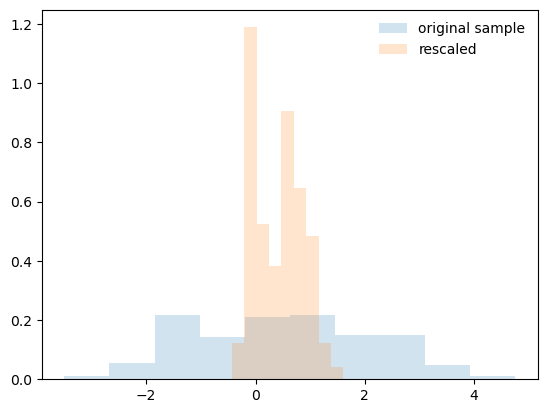

In [667]:
from numpy import inf
res = rescaled_sample.copy()
# res[res == -inf] = -5
# res[res == inf] = 5
fig, ax = plt.subplots(1, 1)
# ax.hist(gene_means, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='means')
ax.hist(sample, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='original sample')
ax.hist(res, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='rescaled')


# ax.hist(rescale, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
# ax.set_xlim(-20, 20)
ax.legend(loc='best', frameon=False)
plt.show()

### Sanity check

In [668]:
# test_sample - using means and variance with no correlations
# sample - using means and covariance including correlations

test_cov = np.zeros((n,n))
np.fill_diagonal(test_cov, gene_vars) 

rv_test = multivariate_normal(gene_means, test_cov, allow_singular=True)
test_sample = rv_test.rvs(size=1, random_state=None) 


In [669]:
len(test_sample)

219

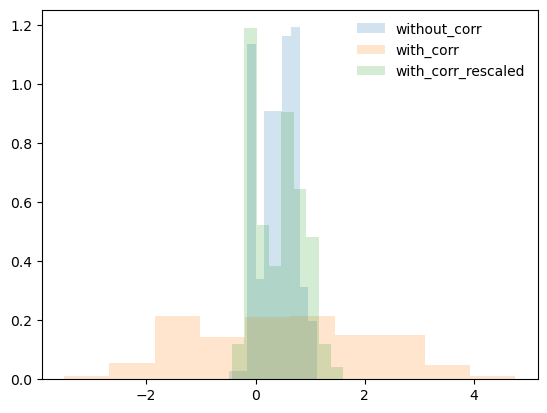

In [670]:
fig, ax = plt.subplots(1, 1)
# ax.hist(gene_means, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='means')
ax.hist(test_sample, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='without_corr')
ax.hist(sample, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='with_corr')
ax.hist(rescaled_sample, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='with_corr_rescaled')


# ax.hist(rescale, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
# ax.set_xlim(-20, 20)
ax.legend(loc='best', frameon=False)
plt.show()

## Example: constructing multivariate normal - set low variance for known expression values (conditional genes)

In [685]:
for row in mod_cov_matrix[:10]:
    print(row[:5])

[2.80019027 0.1        0.008191   0.06498757 0.08615878]
[0.1        2.80918765 0.1        0.1        0.01037864]
[0.008191   0.1        2.80403781 0.02949391 0.1       ]
[0.06498757 0.1        0.02949391 2.80966222 0.05916027]
[0.08615878 0.01037864 0.1        0.05916027 2.80595953]
[0.09778643 0.05409815 0.1        0.08461701 0.06326346]
[0.09928367 0.06917081 0.1        0.08924297 0.07597152]
[0.09558795 0.06851574 0.1        0.09216061 0.07378813]
[0.03406693 0.01073703 0.03553461 0.02701243 0.01500331]
[0.01844869 0.00483368 0.01649165 0.00994963 0.00769766]


In [710]:
# preprocessing
cond_cov_matrix = mod_cov_matrix.copy()
np.fill_diagonal(cond_cov_matrix, gene_vars)
cond_cov_matrix[0][0] = 0.
cond_cov_matrix[1][1] = 0.

In [711]:

# cond_cov_matrix[1:3,2:5] = 0
# cond_cov_matrix[2:5,1:3] = 0
for row in cond_cov_matrix[:10]:
    print(row[:5])

[0.         0.1        0.008191   0.06498757 0.08615878]
[0.1        0.         0.1        0.1        0.01037864]
[0.008191   0.1        0.03845744 0.02949391 0.1       ]
[0.06498757 0.1        0.02949391 0.04408185 0.05916027]
[0.08615878 0.01037864 0.1        0.05916027 0.04037916]
[0.09778643 0.05409815 0.1        0.08461701 0.06326346]
[0.09928367 0.06917081 0.1        0.08924297 0.07597152]
[0.09558795 0.06851574 0.1        0.09216061 0.07378813]
[0.03406693 0.01073703 0.03553461 0.02701243 0.01500331]
[0.01844869 0.00483368 0.01649165 0.00994963 0.00769766]


In [712]:
# adjust matrix to make it positive definite 
w, v = LA.eig(cond_cov_matrix)
cond_cov_matrix = cond_cov_matrix + (abs(np.min(w)) + 1e-7)*np.identity(n)

In [713]:
for row in cond_cov_matrix[:10]:
    print(row[:5])

[2.76591177 0.1        0.008191   0.06498757 0.08615878]
[0.1        2.76591177 0.1        0.1        0.01037864]
[0.008191   0.1        2.80436921 0.02949391 0.1       ]
[0.06498757 0.1        0.02949391 2.80999362 0.05916027]
[0.08615878 0.01037864 0.1        0.05916027 2.80629093]
[0.09778643 0.05409815 0.1        0.08461701 0.06326346]
[0.09928367 0.06917081 0.1        0.08924297 0.07597152]
[0.09558795 0.06851574 0.1        0.09216061 0.07378813]
[0.03406693 0.01073703 0.03553461 0.02701243 0.01500331]
[0.01844869 0.00483368 0.01649165 0.00994963 0.00769766]


In [714]:
mod_gene_stds = gene_stds.copy()
mod_gene_stds[0] = 0
mod_gene_stds[0] = 1
mod_gene_stds

array([1.        , 0.20882356, 0.19610569, 0.20995679, 0.20094566,
       0.24385158, 0.28290245, 0.20945006, 0.22198126, 0.24520724,
       0.2628695 , 0.1834831 , 0.28044837, 0.23865634, 0.23826   ,
       0.20005719, 0.21108741, 0.20985854, 0.26212225, 0.26480426,
       0.25977973, 0.21743511, 0.2590062 , 0.22294972, 0.24862806,
       0.23827463, 0.26945909, 0.22071152, 0.21016382, 0.21171854,
       0.15472029, 0.21320429, 0.20334415, 0.23253429, 0.26477574,
       0.20785715, 0.24817908, 0.24104996, 0.18767385, 0.23115715,
       0.26042853, 0.24586237, 0.23999711, 0.26238668, 0.2761071 ,
       0.28359338, 0.2386538 , 0.30187102, 0.22605601, 0.2237137 ,
       0.23621848, 0.25984292, 0.28376866, 0.28243106, 0.25521836,
       0.30383792, 0.20933322, 0.25869955, 0.25637117, 0.24361392,
       0.19625513, 0.22428705, 0.27031828, 0.26909346, 0.16953728,
       0.24168735, 0.22772291, 0.23689837, 0.28936677, 0.23139414,
       0.31402836, 0.2079133 , 0.24538149, 0.21937021, 0.30317

In [ ]:
def get_patient_sample(means, cov_matrix, gene_stds, allow_singular=False):
    rv = multivariate_normal(means, cov_matrix, allow_singular=allow_singular)
    sample = rv.rvs(size=1, random_state=None) # sample gene expression for a dummy patient
    # account for rescaled variances when making cov matrix positive semidefinite
    rescaled_sample = (sample - means) * gene_stds + means
    return np.clip(rescaled_sample, 0, 1)

patient_sample = get_sample_patient(gene_means, mod_cov_matrix, gene_stds)

In [717]:
test_sample.min()

-0.4818751505309441

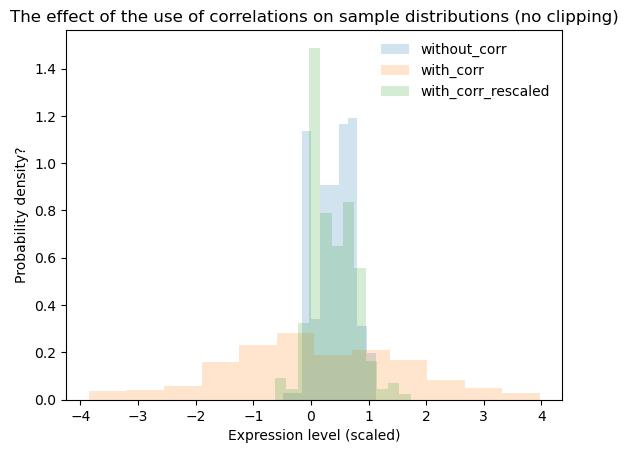

In [734]:
fig, ax = plt.subplots(1, 1)
# ax.hist(gene_means, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='means')
ax.hist(test_sample, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='without_corr')
ax.hist(sample, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label="with_corr")
ax.hist(rescaled_sample, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='with_corr_rescaled')
ax.set_title("The effect of the use of correlations on sample distributions (no clipping)")
ax.set_xlabel("Expression level (scaled)")
ax.set_ylabel("Probability density?")


# ax.hist(rescale, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
# ax.set_xlim(-20, 20)
ax.legend(loc='best', frameon=False)
plt.show()

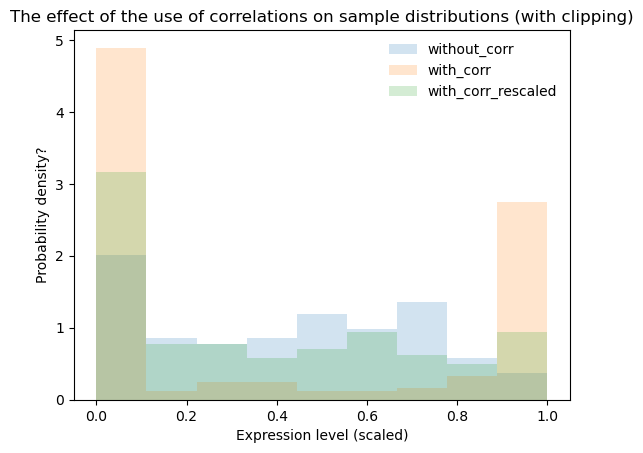

In [735]:
fig, ax = plt.subplots(1, 1)
# ax.hist(gene_means, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='means')
ax.hist(np.clip(test_sample, 0, 1), density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='without_corr')
ax.hist(np.clip(sample, 0, 1), density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='with_corr')
ax.hist(np.clip(rescaled_sample, 0, 1), density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='with_corr_rescaled')
ax.set_title("The effect of the use of correlations on sample distributions (with clipping)")
ax.set_xlabel("Expression level (scaled)")
ax.set_ylabel("Probability density?")


# ax.hist(rescale, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
# ax.set_xlim(-20, 20)
ax.legend(loc='best', frameon=False)
plt.show()

In [ ]:
patient_sample = np.clip(sample, 0, 1)

## Full workflow

In [81]:
from numpy import inf
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler
from numpy import linalg as LA

### Calculate gene statistics

In [82]:
x_stats = x_test_scaled.describe().iloc[[1,2,3,-1]]

In [83]:
x_stats

,AADAC,APOA1,APOA4,APOB,APOC3,AQP9,C6,CEACAM7,CHI3L1,ABCC2,...,TAF15,ZFYVE20,LOC100420253,LY6G5B,C5orf58,RSL24D1P1,MIEN1,PCBP1_AS1,LOC100133165,DNAJB8
mean,0.662326,0.615285,0.670829,0.658361,0.625205,0.459972,0.344742,0.345704,0.546377,0.595752,...,0.359887,0.248426,0.0,0.777372,0.440612,0.0,0.418557,0.331811,0.0,0.009305
std,0.186037,0.208824,0.196106,0.209957,0.200946,0.243852,0.282902,0.209450,0.221981,0.245207,...,0.106041,0.083038,0.0,0.129976,0.238418,0.0,0.197838,0.106248,0.0,0.082177
min,0.165531,0.141475,0.179189,0.041787,0.105744,0.000000,0.000000,0.000000,0.037820,0.077684,...,0.107633,-0.031527,0.0,0.323550,0.000000,0.0,0.048748,0.061934,0.0,0.000000
max,0.930585,1.029728,0.969910,0.950466,0.980092,1.151876,1.191519,0.915734,0.997430,1.042678,...,0.681479,0.404644,0.0,1.013531,1.221905,0.0,1.013627,0.701615,0.0,0.725770


In [84]:
gene_means = x_stats.iloc[0,:].values

In [85]:

gene_stds = x_stats.iloc[1,:].values

In [86]:
gene_vars = np.square(gene_stds)

### Build covariance matrix

In [87]:
n = x_test_scaled.shape[1]
cov = np.zeros((n,n))
cov.shape

(219, 219)

### Calculate correlations using KL divergence

In [88]:


# https://jamesmccaffrey.wordpress.com/2021/02/03/the-kullback-leibler-divergence-for-two-gaussian-distributions/
def kld_gauss(u1, s1, u2, s2):
  # general KL two Gaussians
  # u2, s2 often N(0,1)
  # https://stats.stackexchange.com/questions/7440/ +
  # kl-divergence-between-two-univariate-gaussians
  # log(s2/s1) + [( s1^2 + (u1-u2)^2 ) / 2*s2^2] - 0.5
  v1 = s1 * s1
  v2 = s2 * s2
  if s1 == 0:
    s1 = 0.005
  a = np.log(s2/s1) 
  num = v1 + (u1 - u2)**2
  den = 2 * v2
  if den == 0:
    den = 0.005
  b = num / den
  return a + b - 0.5

def build_cov_matrix(gene_means, gene_stds):
    min_v = inf
    max_v = -inf
    for i in range(n):
        curr_mean = gene_means[i]
        curr_std = gene_stds[i]

        for j in range(i+1, n):
            other_mean = gene_means[j]
            other_std = gene_stds[j]
            kl = kld_gauss(curr_mean, curr_std, other_mean, other_std)
            cov[i][j] = kl

            #max/min
            min_v = min(min_v, kl)
            max_v = max(max_v, kl)
    return cov, min_v, max_v

cov, min_v, max_v = build_cov_matrix(gene_means, gene_stds)
        


C:\Users\shard\AppData\Local\Temp\ipykernel_27476\1465387533.py:12: RuntimeWarning: divide by zero encountered in log
  a = np.log(s2/s1)


In [89]:
print(min_v)
print(max_v)

-inf
3242.75701710342


In [90]:
nans = np.isnan(cov)
np.all(nans == False)

True

In [91]:

cov[cov == -inf] = -max_v

In [92]:
for row in cov[:10]:
    print(row[:5])

[0.         0.03775068 0.00362284 0.01369654 0.02271162]
[0.         0.         0.04422957 0.02107563 0.00273583]
[0.         0.         0.         0.00621603 0.02636019]
[0.         0.         0.         0.         0.01559476]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]


### Scale down correlations

In [93]:

standard_scaler = MinMaxScaler((0,.1))
cov_matrix = standard_scaler.fit_transform(cov)

In [94]:
# reduce scale of correlations even more
# cov_matrix /= 10

In [95]:
for row in cov_matrix[:10]:
    print(row[:5])

[0.         0.1        0.008191   0.06498757 0.08615878]
[0.         0.         0.1        0.1        0.01037864]
[0.         0.         0.         0.02949391 0.1       ]
[0.         0.         0.         0.         0.05916027]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]


### Reflection to lower triangle

In [96]:
# https://stackoverflow.com/questions/16444930/copy-upper-triangle-to-lower-triangle-in-a-python-matrix
i_lower = np.tril_indices(n, -1)
cov_matrix[i_lower] = cov_matrix.T[i_lower]  # make the matrix symmetric

for row in cov_matrix[:10]:
    print(row[:5])

[0.         0.1        0.008191   0.06498757 0.08615878]
[0.1        0.         0.1        0.1        0.01037864]
[0.008191   0.1        0.         0.02949391 0.1       ]
[0.06498757 0.1        0.02949391 0.         0.05916027]
[0.08615878 0.01037864 0.1        0.05916027 0.        ]
[0.09778643 0.05409815 0.1        0.08461701 0.06326346]
[0.09928367 0.06917081 0.1        0.08924297 0.07597152]
[0.09558795 0.06851574 0.1        0.09216061 0.07378813]
[0.03406693 0.01073703 0.03553461 0.02701243 0.01500331]
[0.01844869 0.00483368 0.01649165 0.00994963 0.00769766]


In [97]:
np.fill_diagonal(cov_matrix, gene_vars)

### Processing - conditional genes & matrix adjustment

In [108]:
mod_gene_stds = gene_stds.copy()
mod_gene_means = gene_means.copy()


In [109]:
# if conditional genes, reset corresponding means
mod_gene_means[0] = 0.7
mod_gene_means[1] = 0.6


# then set 0 variances and stds
cond_gene_ids = [0,1]

def set_cond_vars(cond_gene_ids, cov_matrix, gene_stds):
    for idx in cond_gene_ids:
        cov_matrix[idx][idx] = 0.
        mod_gene_stds[idx] = 0.
    return cov_matrix, gene_stds

cov_matrix, mod_gene_stds = set_cond_vars(cond_gene_ids, cov_matrix, mod_gene_stds)

In [110]:

# cond_cov_matrix[1:3,2:5] = 0
# cond_cov_matrix[2:5,1:3] = 0
for row in cov_matrix[:10]:
    print(row[:5])

[0.         0.1        0.008191   0.06498757 0.08615878]
[0.1        0.         0.1        0.1        0.01037864]
[0.008191   0.1        0.03845744 0.02949391 0.1       ]
[0.06498757 0.1        0.02949391 0.04408185 0.05916027]
[0.08615878 0.01037864 0.1        0.05916027 0.04037916]
[0.09778643 0.05409815 0.1        0.08461701 0.06326346]
[0.09928367 0.06917081 0.1        0.08924297 0.07597152]
[0.09558795 0.06851574 0.1        0.09216061 0.07378813]
[0.03406693 0.01073703 0.03553461 0.02701243 0.01500331]
[0.01844869 0.00483368 0.01649165 0.00994963 0.00769766]


In [111]:
# adjust matrix to make it positive definite 
w, v = LA.eig(cov_matrix)
cond_cov_matrix = cov_matrix + (abs(np.min(w)) + 1e-7)*np.identity(n)

In [112]:
for row in cond_cov_matrix[:10]:
    print(row[:5])

[2.76591177 0.1        0.008191   0.06498757 0.08615878]
[0.1        2.76591177 0.1        0.1        0.01037864]
[0.008191   0.1        2.80436921 0.02949391 0.1       ]
[0.06498757 0.1        0.02949391 2.80999362 0.05916027]
[0.08615878 0.01037864 0.1        0.05916027 2.80629093]
[0.09778643 0.05409815 0.1        0.08461701 0.06326346]
[0.09928367 0.06917081 0.1        0.08924297 0.07597152]
[0.09558795 0.06851574 0.1        0.09216061 0.07378813]
[0.03406693 0.01073703 0.03553461 0.02701243 0.01500331]
[0.01844869 0.00483368 0.01649165 0.00994963 0.00769766]


In [113]:
def get_patient_sample(means, cov_matrix, gene_stds, allow_singular=False):
    rv = multivariate_normal(means, cov_matrix, allow_singular=allow_singular)
    sample = rv.rvs(size=1, random_state=None) # sample gene expression for a dummy patient
    # account for rescaled variances when making cov matrix positive semidefinite
    rescaled_sample = (sample - means) * gene_stds + means
    return np.clip(rescaled_sample, 0, 1)

patient_sample = get_patient_sample(mod_gene_means, cond_cov_matrix, mod_gene_stds)

In [114]:
patient_sample.min()

0.0

In [115]:
# test_sample using only variance, no correlations
test_cov = np.zeros((n,n))
np.fill_diagonal(test_cov, gene_vars) 

rv_test = multivariate_normal(gene_means, test_cov, allow_singular=True)
test_sample = np.clip(rv_test.rvs(size=1, random_state=None), 0, 1)

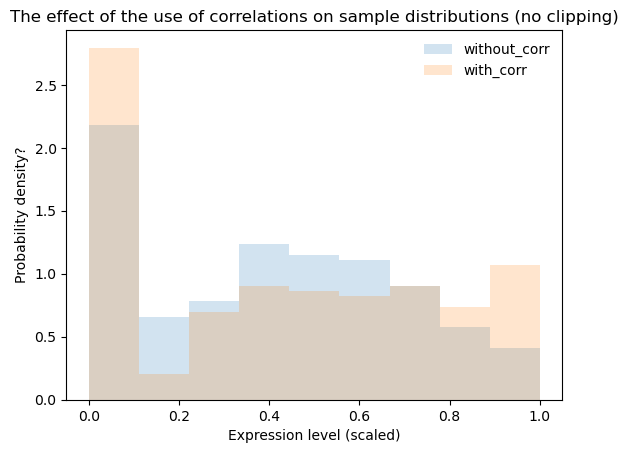

In [116]:
fig, ax = plt.subplots(1, 1)
# ax.hist(gene_means, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='means')
ax.hist(test_sample, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='without_corr')
ax.hist(patient_sample, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label="with_corr")
# ax.hist(rescaled_sample, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label='with_corr_rescaled')
ax.set_title("The effect of the use of correlations on sample distributions (no clipping)")
ax.set_xlabel("Expression level (scaled)")
ax.set_ylabel("Probability density?")


# ax.hist(rescale, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
# ax.set_xlim(-20, 20)
ax.legend(loc='best', frameon=False)
plt.show()

## Calculate SHAP values

In [40]:
shap_values[0].shape

NameError: name 'shap_values' is not defined

In [41]:
shap_values = explainer.shap_values(X=x_test_scaled[:2])

Calculating SHAP values


  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step
initial synthetic data: [[0.70281301 0.79905181 0.71966466 ... 0.62264083 0.         1.        ]
 [0.75140807 0.6037073  0.62276799 ... 0.30117921 0.         0.        ]
 [0.70281301 0.79905181 0.71966466 ... 0.62264083 0.         1.        ]
 ...
 [0.75140807 0.6037073  0.62276799 ... 0.30117921 0.         0.        ]
 [0.70281301 0.79905181 0.71966466 ... 0.62264083 0.         1.        ]
 [0.75140807 0.6037073  0.62276799 ... 0.30117921 0.         0.        ]]
shape: 4820
219
synthetic samples generated: [[0.86918482 0.79905181 0.71966466 ... 0.62264083 0.         1.        ]
 [0.86918482 0.6037073  0.62276799 ... 0.30117921 0.         0.        ]
 [0.70281301 0.84188037 0.9301712  ... 0.34991969 0.         0.        ]
 ...
 [0.75140807 0.84188037 0.9301712  ... 0.34991969 0.         0.        ]
 [0.86918482 0.79905181 0.71966466 ... 0.62264083 0.         0.        ]
 [0.86918482 0.6037073  0.62276799 ... 0.30117921 0.         0.  

In [ ]:
shap_values

## Save SHAP values

In [42]:
# with open("shap_values", "wb") as fp:   #Pickling
#     pickle.dump(shap_values, fp)

In [43]:


with open("../shap_values", "rb") as fp:   # Unpickling
    shap_values = pickle.load(fp)

In [44]:
print(f'length of SHAP values: {len(shap_values)}')
print(f'Shape of each element: {shap_values[0].shape}')

length of SHAP values: 3
Shape of each element: (78, 219)
